In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
# import required libraries
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt


#Setting Random Seed
# tf.random.set_seed(195470)

# load and prepare the training and test data
def load_Fashion_MNIST():
    fashion_mnist = tf.keras.datasets.fashion_mnist

    # load the training and test data    
    (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

    # reshape the feature data
    tr_x = tr_x.reshape(tr_x.shape[0], 784)
    te_x = te_x.reshape(te_x.shape[0], 784)

    # noramlise feature data
    tr_x = tr_x / 255.0
    te_x = te_x / 255.0

    print( "Shape of training features ", tr_x.shape)
    print( "Shape of test features ", te_x.shape)


    # one hot encode the training labels and get the transpose
    tr_y = np_utils.to_categorical(tr_y,10)
    tr_y = tr_y.T
    print ("Shape of training labels ", tr_y.shape)

    # one hot encode the test labels and get the transpose
    te_y = np_utils.to_categorical(te_y,10)
    te_y = te_y.T
    print ("Shape of testing labels ", te_y.shape)
    
    # Reshape the training data and test data so 
    # that the features becomes the rows of the matrix
    tr_x = tr_x.T
    te_x = te_x.T

    print("Reshaped training data ", tr_x.shape)
    print("Reshaped test data ",te_x.shape)
    
    return tr_x, tr_y, te_x, te_y

In [10]:
#  push a matrix of feature data through the neural network and the final Softmax layer
def forward_pass(x, w_1, b1, w_2, b2, w_3, b3,dropOutProb=0.01):

    #Setting probability threshold for dropout layer
    probThreshold = 1-dropOutProb

    # First Layer
    A1 = tf.matmul(w_1, x) + b1 #WX + b
    H1 =  tf.keras.activations.relu(A1) #ReLu activation
    #Applyting dropout to H1
    drop_matrix = tf.cast(tf.random.uniform(shape=H1.shape)<probThreshold,tf.float32)
    H1 = tf.divide(tf.multiply(H1,drop_matrix),probThreshold)
    
    # Second Layer
    A2 = tf.matmul(w_2, H1) + b2 #WX + b
    H2 =  tf.keras.activations.relu(A2) #ReLu activation

    # Third Layer / Output Layer
    A3 = tf.matmul(w_3, H2) + b3 #WX + b

    #SoftMax activation
    e_A3 = tf.math.exp(A3) #e^A3
    return tf.divide(e_A3,tf.reshape(tf.reduce_sum(e_A3,0),[1, -1])) #e^A3/sum(e^A3)

In [4]:

def cross_entropy(y, y_pred):
    # mean of cross entropy loss
    return tf.reduce_mean(-(tf.reduce_sum(tf.multiply(y, tf.math.log(y_pred)), 0))) #mean(-sum(y*log(h(x)))

In [5]:

def calculate_accuracy(y, y_pred_softmax):
    #Compare every predicted value to original value individually which will result in boolean array which will be casted to zeros and ones
    #Taking the mean of this array will give us the accuracy since 1 is correct and 0 is wrong and the mean is accuracy!
    #Example tf.Tensor([ True False False ... False False False], shape=(60000,), dtype=bool) casted to [1. 0. 0. ... 0. 0. 0.], shape=(60000,), dtype=float32)
    #and the Mean gives 0.10131667 which is the accuracy
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred_softmax, 0), tf.argmax(y, 0)), tf.float32))  


In [6]:
#Function to type cast to float32 by default
def fl_type_caster(x,t=tf.float32):
  return tf.cast(x,t)

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)
Reshaped training data  (784, 60000)
Reshaped test data  (784, 10000)
+---------------------+---------------------+---------------------+---------------------+---------------------+
|        Epoch        |    Training_loss    |  Training_accuracy  |   Validation_loss   | Validation_accuracy |
+---------------------+---------------------+---------------------+---------------------+---------------------+
|          1          |       2.69362       |       0.12373       |       2.68817       |       0.1253        |
|          2          |       2.10308       |       0.25482       |       2.10154       |       0.2563        |
|          3          |       1.82797       |       0.40982       |       1.82983       |        0.414        |
|          4          |       1.60505       |       0.50563       |       1.60813       |       0.5048   

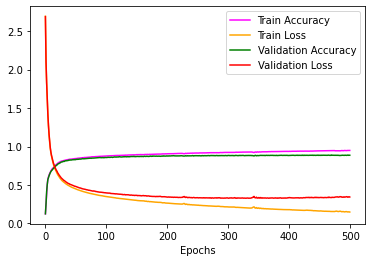

In [11]:
#Number of Iterations
epochs = 500
training_accuracy, training_loss, validation_accuracy, validation_loss = [],[],[],[]

# load the prepared data and typecast the training and test data
tr_x, tr_y, te_x, te_y = [fl_type_caster(i) for i in load_Fashion_MNIST()]

#Initializing the weights and biases for 1st layer
w1 = tf.Variable(tf.random.normal([300, tr_x.shape[0]], mean=0.0, stddev=0.1))
b1 = tf.Variable(tf.zeros([300, 1]))

#Initializing the weights and biases for 2nd layer
w2 = tf.Variable(tf.random.normal([100, 300], mean=0.0, stddev=0.1))
b2 = tf.Variable(tf.zeros([100, 1]))

#Initialize the weights and biases for the SoftMax ie Output layer
w3 = tf.Variable(tf.random.normal([ tr_y.shape[0], 100], mean=0.0, stddev=0.1))
b3 = tf.Variable(tf.zeros([tr_y.shape[0], 1]))

#Instantiate Optimizer
adam_optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(epochs):
    if i%10 == 0:
      print("+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))
      print("| {:^19} | {:^19} | {:^19} | {:^19} | {:^19} |".format("Epoch","Training_loss","Training_accuracy","Validation_loss","Validation_accuracy"))
      print("+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))

    # Instantiating Gradient Tape to monitor the forward pass & calculate gradients ie autodiff
    with tf.GradientTape() as tape:
        y_pred = forward_pass(tr_x, w1, b1, w2, b2, w3, b3)
        loss = cross_entropy(tr_y, y_pred)
    training_loss.append(loss)
    
    # Prediction Accuracy
    accuracy = calculate_accuracy(tr_y, y_pred)
    training_accuracy.append(accuracy)

    # Calculate gradients
    gradients = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])

    # Forward propagate and calculate accuracy and loss for the valdation data
    te_y_pred = forward_pass(te_x, w1, b1, w2, b2, w3, b3) 
    val_loss = cross_entropy(te_y, te_y_pred)
    val_accuracy = calculate_accuracy(te_y, te_y_pred) 
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss)

    print("| {:^19} | {:^19} | {:^19} | {:^19} | {:^19} |".format(i+1,round(float(loss.numpy()),5),round(float(accuracy.numpy()),5),round(float(val_loss.numpy()),5),round(float(val_accuracy.numpy()),5)))
    
    # Adam Optimizer to update the weights and biases accordingly
    adam_optimizer.apply_gradients(zip(gradients, [w1, b1, w2, b2, w3, b3]))

print("+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+-{:^19}-+".format("-"*19,"-"*19,"-"*19,"-"*19,"-"*19))

# Plot the training and the validation accuracy and loss
plt.plot(training_accuracy, label="Train Accuracy",color='magenta')
plt.plot(training_loss, label="Train Loss",color='orange')
plt.plot(validation_accuracy, label="Validation Accuracy",color='green')
plt.plot(validation_loss, label="Validation Loss",color='red')
plt.xlabel("Epochs")
plt.legend()
plt.show()

